# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key=''
binance_api_secret=''
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))/100).to_dict()
inventory_weights.pop('Total')
inventory_weights

{'BTCUSDT': 0.3779,
 'JASMYUSDT': 0.17859999999999998,
 'ETHUSDT': 0.13419999999999999,
 'SOLUSDT': 0.12210000000000001,
 'BBUSDT': 0.0659,
 'MKRUSDT': 0.0649,
 'PEPEUSDT': 0.0347,
 'BNBUSDT': 0.0216,
 'TRXUSDT': 0.0,
 'FETUSDT': 0.0}

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.sort_index()
positions.index=pd.to_datetime(positions.index)

2024-05-05 00:00:00
2024-06-04 00:00:00
LDUMAUSDT not retrieved


In [13]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [14]:
positions.to_excel('Positions.xlsx')

In [15]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [16]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=np.log(1+binance_data.pct_change())

LDUMAUSDT not retrieved
Total not retrieved


In [17]:
historical_ptf=pd.DataFrame()

In [18]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

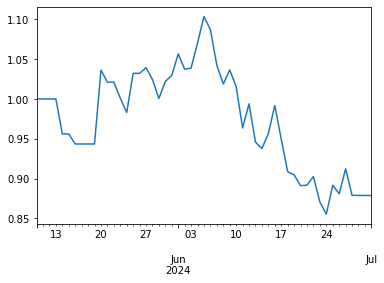

In [19]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [20]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [21]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [22]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'AGIXUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT',
       'ENSUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT',
       'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GNOUSDT',
       'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT',
       'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT',
       'NEOUSDT', 'OPUSDT', 'ORDIUSDT', 'PENDLEUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RNDRUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT',
       'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT',
       'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

## Optimal Portfolio

In [23]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[21]-0.15},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[13]-0.3}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
BTCUSDT,0.300000
BNBUSDT,0.256085
ETHUSDT,0.150000
JASMYUSDT,0.127336
PEPEUSDT,0.099095
PENDLEUSDT,0.067484


In [24]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.3},
                                                           {'type': 'ineq', 'fun': lambda weights: weights[2]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
JASMYUSDT,0.55
BTCUSDT,0.30
ETHUSDT,0.15


## Real Portfolio vs Optimal

In [25]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current*100],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,675.275936,37.794889,30.0,7.794889
JASMYUSDT,319.183165,17.864538,55.0,-37.135462
ETHUSDT,239.861476,13.424938,15.0,-1.575062
SOLUSDT,218.158364,12.210225,0.0,0.000000
BBUSDT,117.672674,6.586086,0.0,0.000000
MKRUSDT,115.916121,6.487773,0.0,0.000000
PEPEUSDT,62.023444,3.471424,0.0,0.000000
BNBUSDT,38.535061,2.156790,0.0,0.000000
TRXUSDT,0.030506,0.001707,0.0,0.000000
FETUSDT,0.029108,0.001629,0.0,0.000000


In [26]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory*100],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,675.275936,37.794889,30.0000,7.794889
JASMYUSDT,319.183165,17.864538,12.7336,5.130938
ETHUSDT,239.861476,13.424938,15.0000,-1.575062
SOLUSDT,218.158364,12.210225,0.0000,0.000000
BBUSDT,117.672674,6.586086,0.0000,0.000000
MKRUSDT,115.916121,6.487773,0.0000,0.000000
PEPEUSDT,62.023444,3.471424,9.9095,-6.438076
BNBUSDT,38.535061,2.156790,25.6085,-23.451710
TRXUSDT,0.030506,0.001707,0.0000,0.000000
FETUSDT,0.029108,0.001629,0.0000,0.000000


## Risk Reward Analysis

<AxesSubplot:>

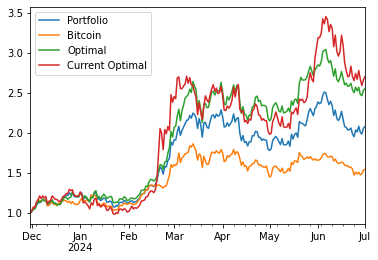

In [27]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf
(1+portfolio_perf).cumprod().plot()

In [28]:
portfolio_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

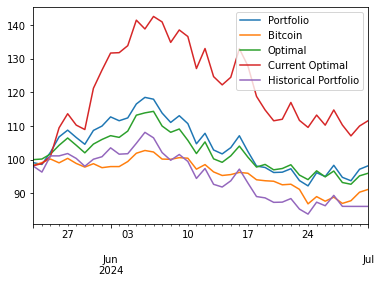

In [29]:
((1+portfolio_perf.iloc[-40:]).cumprod()*100).plot()

In [30]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.507079
dtype: float64

In [31]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio               0.500366
Bitcoin                 0.439763
Optimal                 0.508240
Current Optimal         0.738040
Historical Portfolio    0.441602
dtype: float64

In [32]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.232655,0.242229,0.248761,0.109665,0.139096
BTCUSDT,0.113413,0.189657,0.350943,0.150502,0.200441
ETHUSDT,0.053828,0.093126,0.167730,0.037626,0.130104
JASMYUSDT,0.226475,0.185965,0.094647,0.027115,0.067532
PENDLEUSDT,0.091886,0.081915,0.049405,0.007616,0.041789
PEPEUSDT,0.281743,0.207109,0.088514,0.016421,0.072093


In [33]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,-0.024287,0.349273,0.432949,0.217286,0.215663
JASMYUSDT,1.042915,0.240212,0.152345,0.048533,0.103812
ETHUSDT,0.254336,0.142774,0.139919,0.027402,0.112517
SOLUSDT,-0.044993,0.110204,0.127867,0.022683,0.105184
BBUSDT,-0.194022,0.047383,0.047563,0.006608,0.040955
MKRUSDT,-0.063896,0.055727,0.060011,0.006409,0.053603
PEPEUSDT,0.037546,0.034906,0.021093,0.001832,0.019261
BNBUSDT,-0.007600,0.019521,0.018252,0.000710,0.017542


## Value At Risk

### Historical

In [34]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.046831827451863726, -0.06387113337382667)

In [35]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.043192331851789174, -0.04800480207948082)

### Parametric

In [36]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.05266182921135265, -0.06749790485956798)

In [37]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.053666801046306244, -0.06878600089265488)

### Multivariate

In [38]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.04779026001806128, -0.06087969159805467)

In [39]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05196856125166565, -0.06618051792516377)

### Copulas

In [58]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.046345457257843954, -0.06028331293280658)

In [41]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05188993461387593, -0.06475391901547897)

In [42]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.04749480062348215, -0.06146293519816696)

In [43]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.050599521056702894, -0.06525684374057583)

### Monte Carlo

In [44]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05326794571161397, -0.06574191148725549)

In [45]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.054262580622638196, -0.06778449818464911)

### VaR Violation

In [46]:
var_data=rolling_var(returns_to_use,opt_weights,window=15,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.027880,-0.051889,-0.046388,0.000758
2023-12-31,-0.027880,-0.052257,-0.049149,-0.004994
2024-01-01,-0.027496,-0.052681,-0.044966,0.036666
2024-01-02,-0.027496,-0.053858,-0.045831,-0.010166
2024-01-03,-0.038043,-0.060673,-0.055422,-0.039530
...,...,...,...,...
2024-06-27,-0.045599,-0.055960,-0.062722,0.018215
2024-06-28,-0.034839,-0.052704,-0.058357,-0.035336
2024-06-29,-0.034839,-0.052581,-0.056634,-0.005558
2024-06-30,-0.034839,-0.054080,-0.057544,0.027005


In [47]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=5,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-18,-0.034069,-0.111678,-0.099378,0.008469
2024-05-19,-0.029960,-0.107903,-0.093928,-0.027066
2024-05-20,-0.029960,-0.124268,-0.109592,0.100735
2024-05-21,-0.026312,-0.114926,-0.095928,-0.008222
2024-05-22,-0.026312,-0.116237,-0.102672,-0.001912
2024-05-23,-0.026356,-0.118906,-0.108000,-0.009315
2024-05-24,-0.009272,-0.111437,-0.096788,-0.005289
2024-05-25,-0.009272,-0.045323,-0.044107,0.036903
2024-05-26,-0.009154,-0.059497,-0.047878,0.044467
2024-05-27,-0.009154,-0.056305,-0.039531,0.018830


<AxesSubplot:>

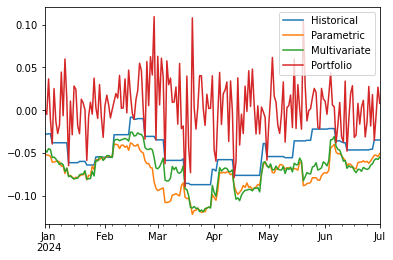

In [48]:
var_data.plot()

<AxesSubplot:>

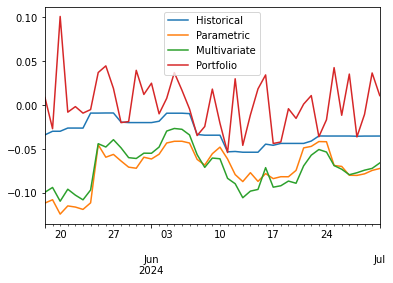

In [49]:
current_var_data.plot()

In [50]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064865,0.0,0.0
Kupiec Stat,0.79005,18.978519,18.978519
P-value,0.374085,0.000013,0.000013


In [51]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.111111,0.0,0.0
Kupiec Stat,2.665898,4.616396,4.616396
P-value,0.10252,0.031668,0.031668


## Principal Component Analysis

In [52]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.75908526, 0.08053067, 0.06254686, 0.05035683, 0.04748039])

In [53]:
eigval,eigvec,portfolio_components=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.57006045, 0.17799874, 0.10999432, 0.09709517, 0.04485132])

In [54]:
position

,BTCUSDT,ETHUSDT,FDUSDUSDT,FETUSDT,INJUSDT,MKRUSDT,RNDRUSDT,SOLUSDT,TNSRUSDT,TRXUSDT,...,BNBUSDT,NEARUSDT,PEPEUSDT,XRPUSDT,ARUSDT,ENSUSDT,JASMYUSDT,LDUMAUSDT,LPTUSDT,NOTUSDT
2024-05-14,108.786488,39.610745,0,13.986206,23.113368,18.301372,42.606286,119.262037,14.497446,10.453518,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-16,115.248436,40.473488,0,15.955786,25.364108,18.390147,42.640249,133.842113,15.492836,10.421979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-20,126.221886,50.329408,0,16.970913,30.558124,21.620202,46.155395,156.840658,0.000000,10.387137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-21,123.928266,52.086233,0,17.697309,29.908872,20.930487,47.522396,149.669115,0.000000,10.322871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-23,120.079262,52.003903,0,16.543069,28.274921,19.380333,43.451110,148.019083,0.000000,9.636823,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-24,227.732664,207.739687,0,16.183346,27.820445,123.646859,42.920442,245.526328,0.000000,9.652494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-25,230.192974,208.908692,0,16.082707,27.420073,125.714382,42.780346,246.488410,0.000000,9.514312,...,0.000000,105.742169,103.716625,104.445604,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-27,484.620453,216.985861,0,0.026694,0.053728,124.321051,43.145445,249.144948,0.000000,0.006110,...,0.000000,100.564272,115.771864,102.979971,52.604936,84.169058,127.936518,6.155042,97.598483,NaN
2024-05-28,529.636093,214.226050,0,0.030237,0.054751,122.163636,43.387430,247.002628,0.000000,0.010128,...,0.000000,99.022466,110.852772,101.957885,49.691861,87.191890,122.613036,6.155042,99.590476,NaN
2024-05-29,573.439502,209.921124,0,0.033950,0.055126,120.815251,43.684604,246.484258,0.000000,0.014334,...,0.000000,48.158812,102.261682,101.012938,50.965108,82.859165,121.387867,6.155042,96.430763,NaN
